In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from raindrop.config import cfg
from raindrop.dropgenerator import generate_label, generateDrops


def see_plot(pict, color='gray', size=(5,5), title=''):
    plt.figure(figsize=size)
    plt.imshow(pict, cmap=color)
    plt.title(title)
    plt.xticks()
    plt.show()

def create_empty_mask(img_shape):
    """Create empty mask with the same shape as input image"""
    return np.zeros((img_shape[0], img_shape[1], 3), dtype=np.uint8)

def get_random_config(base_cfg, variation_type='normal'):
    """Generate random configuration based on base config with high variety"""
    new_cfg = dict(base_cfg)  # создаем копию словаря
    
    if variation_type == 'normal':
        # Стандартные параметры для изображений с масками
        new_cfg['MIN_RADIUS'] = random.randint(3, 35)  # Больший диапазон для минимального радиуса
        new_cfg['MAX_RADIUS'] = random.randint(40, 120)  # Больший диапазон для максимального радиуса
        new_cfg['DROP_RATIO'] = random.uniform(0.2, 0.7)  # Больший диапазон для плотности капель
        new_cfg['ALPHA_LOW'] = random.uniform(0.1, 0.4)  # Больший диапазон для минимальной прозрачности
        new_cfg['ALPHA_HIGH'] = random.uniform(0.5, 0.9)  # Больший диапазон для максимальной прозрачности
        
    elif variation_type == 'empty':
        # Более агрессивные параметры для изображений без масок
        new_cfg['MIN_RADIUS'] = random.randint(2, 40)  # Еще больший диапазон для минимального радиуса
        new_cfg['MAX_RADIUS'] = random.randint(45, 150)  # Еще больший диапазон для максимального радиуса
        new_cfg['DROP_RATIO'] = random.uniform(0.15, 0.8)  # Еще больший диапазон для плотности капель
        new_cfg['ALPHA_LOW'] = random.uniform(0.05, 0.45)  # Еще больший диапазон для минимальной прозрачности
        new_cfg['ALPHA_HIGH'] = random.uniform(0.5, 0.95)  # Еще больший диапазон для максимальной прозрачности
    
    # Общие случайные параметры с большей вариативностью
    new_cfg['BLUR_RATIO'] = random.uniform(0.05, 0.4)  # Больший диапазон размытия
    new_cfg['BLUR_RADIUS'] = random.randint(1, 11)  # Больший диапазон радиуса размытия
    
    # Добавляем новые параметры для большего разнообразия
    new_cfg['NOISE_RATIO'] = random.uniform(0, 0.15)  # Добавление шума
    new_cfg['DISTORTION_SCALE'] = random.uniform(0.8, 1.2)  # Масштаб искажения
    new_cfg['BRIGHTNESS_ADJUST'] = random.uniform(0.85, 1.15)  # Корректировка яркости
    new_cfg['CONTRAST_ADJUST'] = random.uniform(0.9, 1.1)  # Корректировка контраста
    
    # Случайные параметры формы капель
    new_cfg['ELLIPTICITY'] = random.uniform(0.7, 1.3)  # Эллиптичность капель
    new_cfg['ANGLE_VARIATION'] = random.uniform(-30, 30)  # Вариация угла наклона
    new_cfg['EDGE_DARKENING'] = random.uniform(0.0, 0.3)  # Затемнение краев капель
    
    # Параметры распределения
    distribution_types = ['uniform', 'gaussian', 'cluster']
    new_cfg['DISTRIBUTION_TYPE'] = random.choice(distribution_types)
    new_cfg['CLUSTER_PROBABILITY'] = random.uniform(0.1, 0.4)  # Вероятность образования кластеров
    
    return new_cfg
    
def synt_generation(real_img_fullpath, real_msk_fullpath=None, cfg=None, verbose=False):
    
    img = cv2.imread(real_img_fullpath)[:,:,::-1]
    if real_msk_fullpath:
        msk = cv2.imread(real_msk_fullpath)[:,:,::-1]
    else:
        msk = create_empty_mask(img.shape)
        
    (h, w, c) = img.shape

    if verbose:
        mrg = img.copy()
        mrg[:,:,0] = mrg[:,:,0]//5*4+msk[:,:,0]//5
        see_plot(np.concatenate([img,msk,mrg],axis=1), size=(20,5), title='REAL image-mask-merged')
    
    # main synt generation
    List_of_Drops, label_map  = generate_label(h, w, cfg)
    synt_img, _, synt_msk = generateDrops(real_img_fullpath, cfg, List_of_Drops)
    
    # pill-image to numpy-image
    synt_img = np.array(synt_img)
    synt_msk = np.array(synt_msk)
    
    if len(synt_msk.shape)==3: 
        synt_msk = synt_msk[:,:,0]
    synt_msk = np.stack((synt_msk,)*3, axis=-1)
    
    # совмещение реальной маски и синтетической
    synt_msk = (((msk>0).astype(int)+(synt_msk>0).astype(int))>0).astype(np.uint8)*255
    
    if verbose:
        merged = synt_img.copy()
        merged[:,:,0] = merged[:,:,0]//5*4+synt_msk[:,:,0]//5
        for_plot = np.concatenate([synt_img,synt_msk,merged],axis=1)
        see_plot(for_plot, size=(20,5), title=f'SYNT image-mask-merged')
        
    return synt_img,synt_msk

In [14]:
# Создаем директории для сохранения результатов
output_dirs = [
    'synthetic_data/raindrop/img',
    'synthetic_data/raindrop/msk',
    'synthetic_data/empty/img',
    'synthetic_data/empty/msk'
]

for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)

# Обработка изображений с масками (raindrop_image)
print("Processing raindrop images...")
raindrop_images = sorted(os.listdir('raindrop_image/img'))

for img_name in tqdm(raindrop_images):
    img_path = os.path.join('raindrop_image/img', img_name)
    msk_path = os.path.join('raindrop_image/msk', os.path.splitext(img_name)[0] + '.png')
    
    # Генерируем 3 разных версии
    for i in range(5):
        random_cfg = get_random_config(cfg, 'normal')
        synt_img, synt_msk = synt_generation(img_path, msk_path, random_cfg)
        
        # Сохраняем результаты
        base_name = os.path.splitext(img_name)[0]
        cv2.imwrite(f'synthetic_data/raindrop/img/{base_name}_synt{i}.jpg', synt_img[:,:,::-1])
        cv2.imwrite(f'synthetic_data/raindrop/msk/{base_name}_synt{i}.png', synt_msk[:,:,::-1])

# Обработка изображений без масок (empty_image)
print("\nProcessing empty images...")
empty_images = sorted(os.listdir('empty_image/img'))

for img_name in tqdm(empty_images):
    img_path = os.path.join('empty_image/img', img_name)
    
    # Генерируем 5 разных версий
    for i in range(8):
        random_cfg = get_random_config(cfg, 'empty')
        synt_img, synt_msk = synt_generation(img_path, None, random_cfg)
        
        # Сохраняем результаты
        base_name = os.path.splitext(img_name)[0]
        cv2.imwrite(f'synthetic_data/empty/img/{base_name}_synt{i}.jpg', synt_img[:,:,::-1])
        cv2.imwrite(f'synthetic_data/empty/msk/{base_name}_synt{i}.png', synt_msk[:,:,::-1])

print("\nGeneration completed!")

Processing raindrop images...


100%|███████████████████████████████████████████| 76/76 [01:59<00:00,  1.57s/it]



Processing empty images...


100%|█████████████████████████████████████████| 163/163 [04:20<00:00,  1.60s/it]


Generation completed!


Random examples from raindrop images:


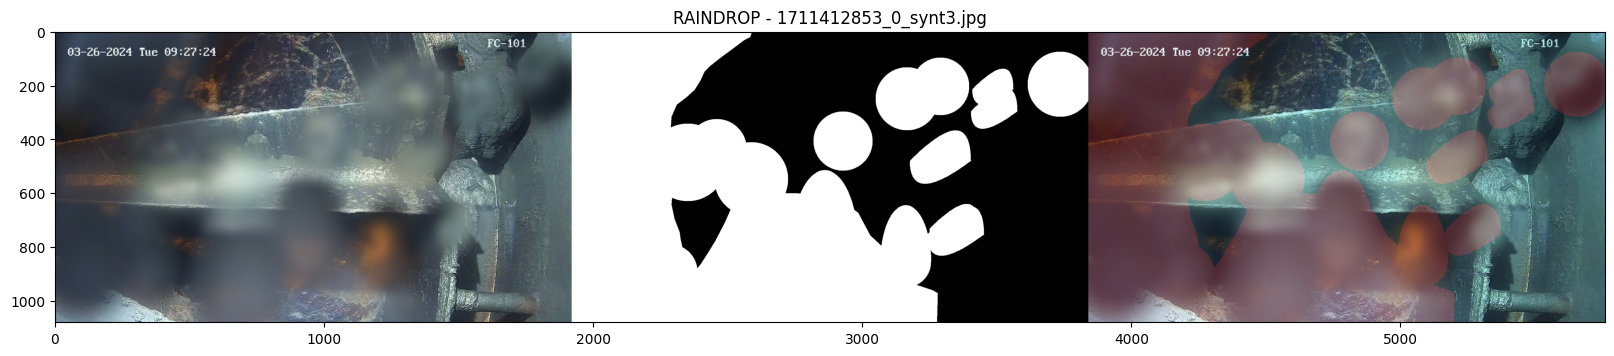

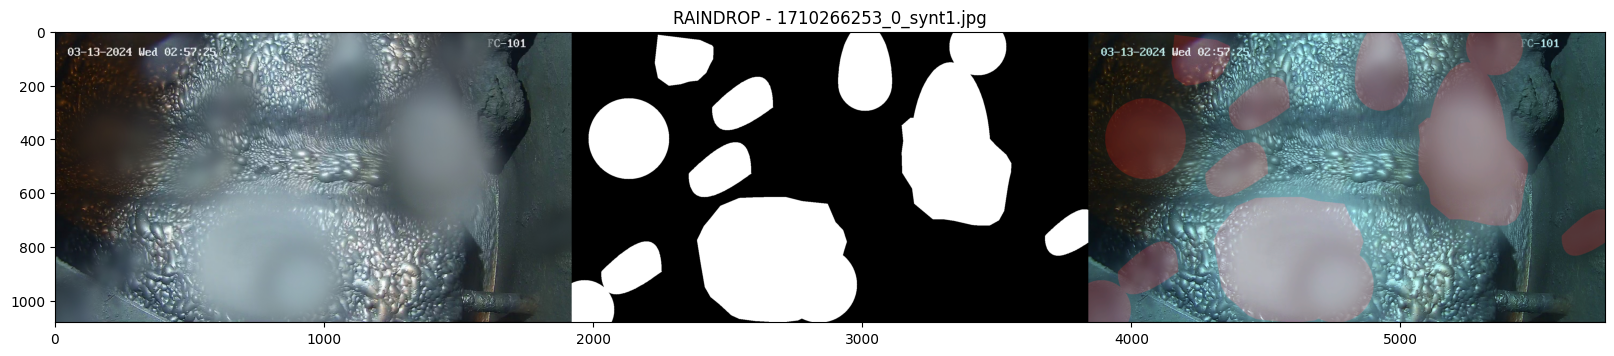

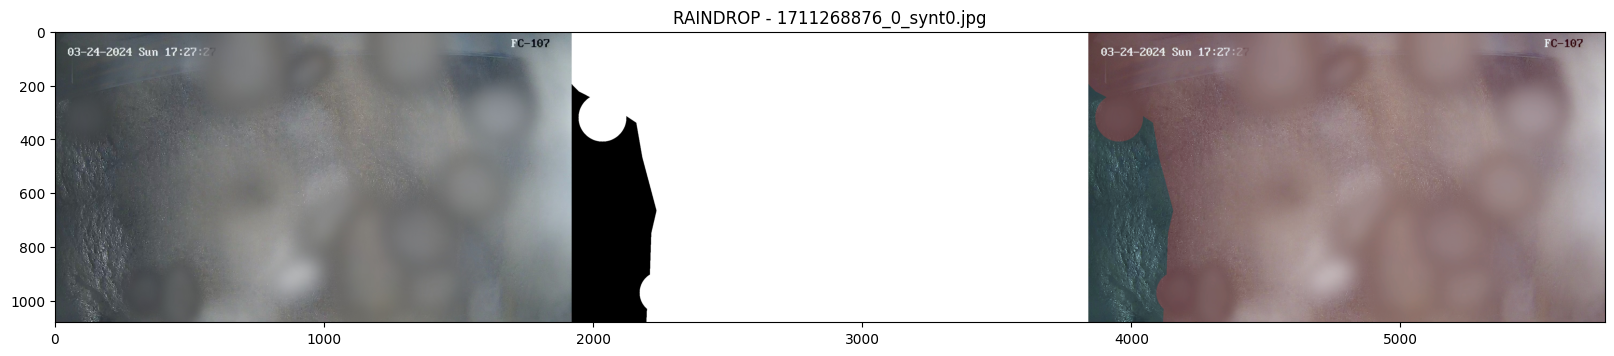

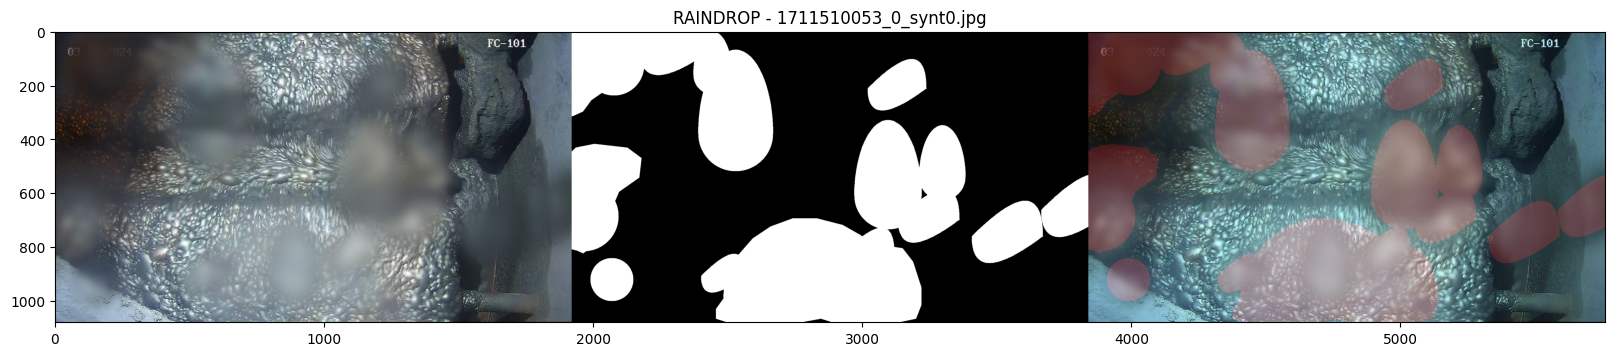

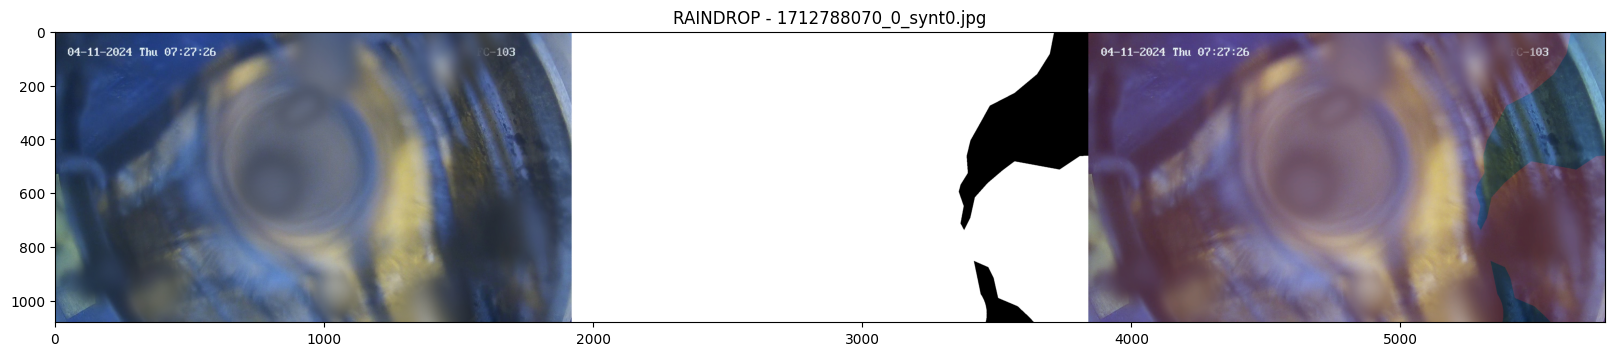


Random examples from empty images:


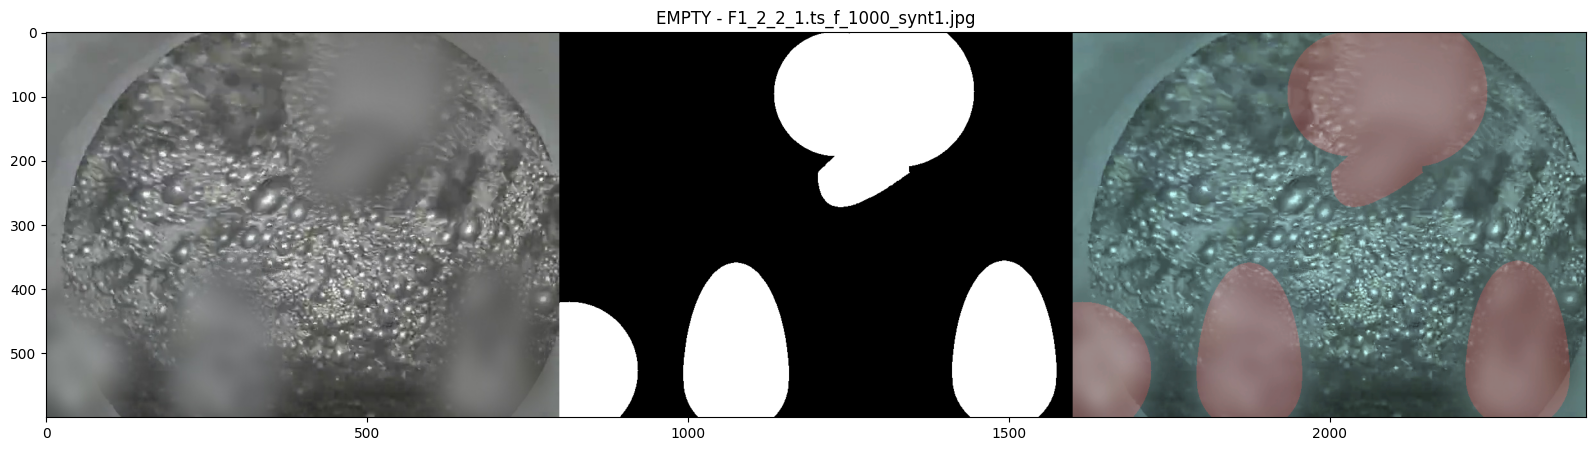

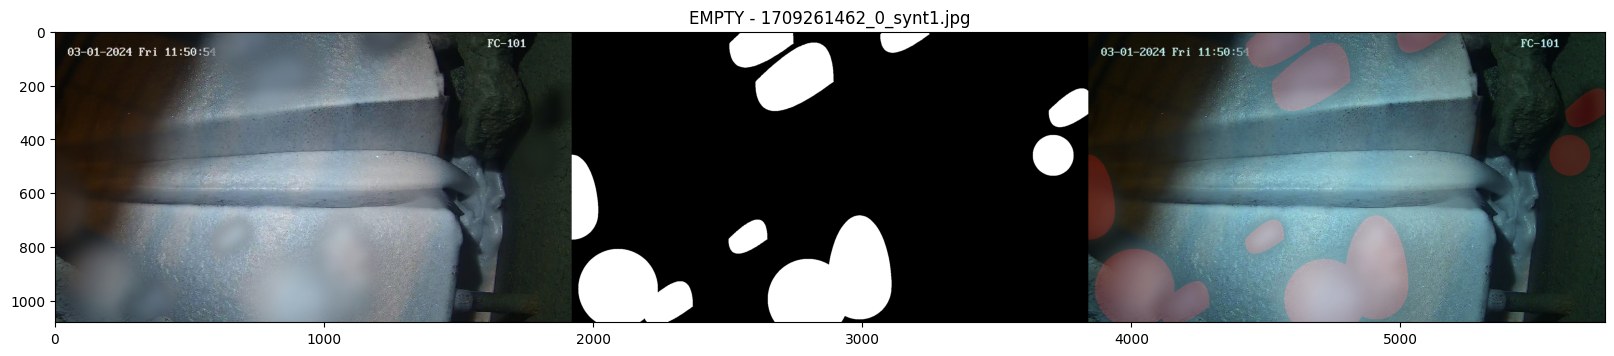

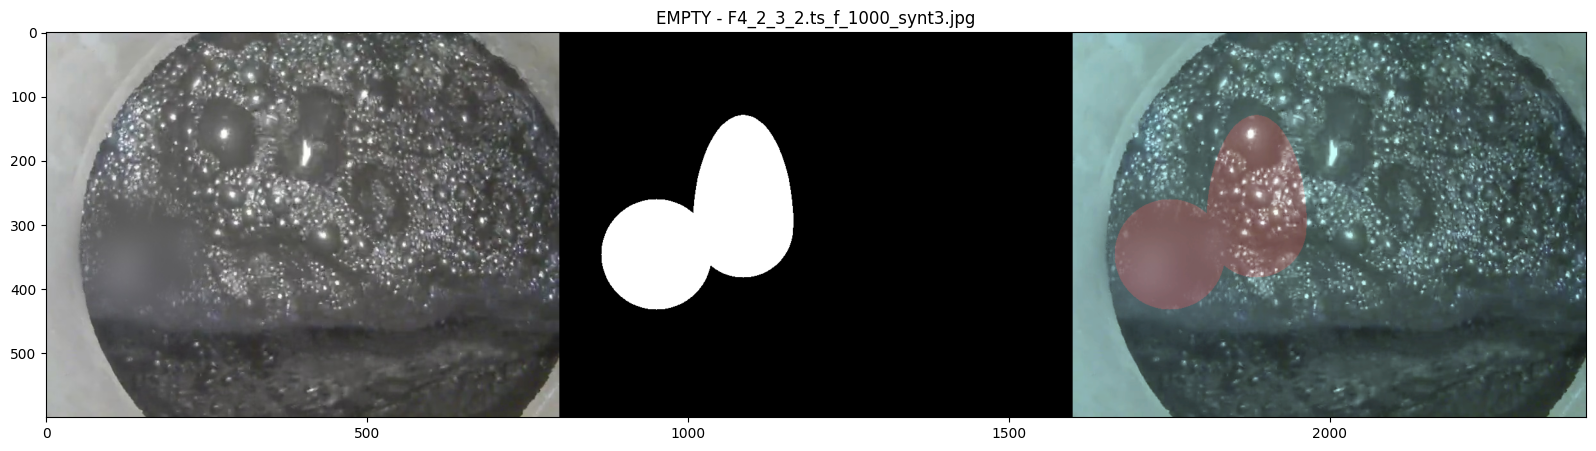

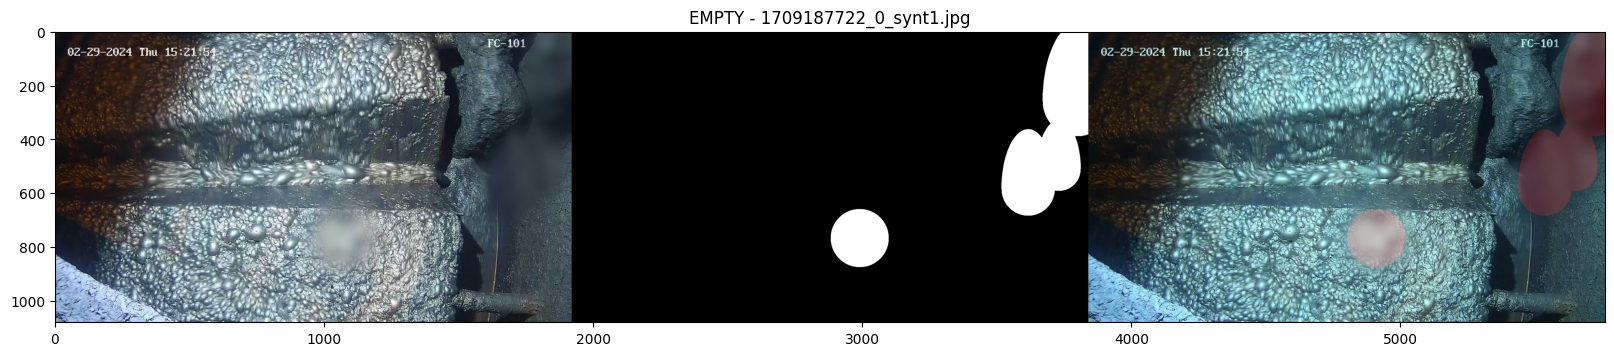

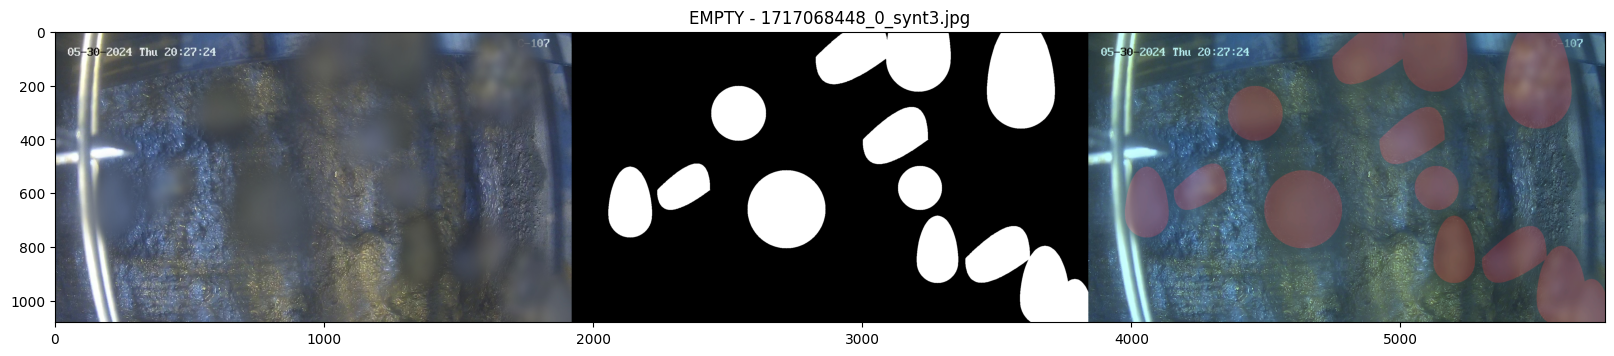

In [15]:
# Визуализация примеров сгенерированных изображений
def show_random_examples(source_type='raindrop', num_examples=5):
    base_path = f'synthetic_data/{source_type}'
    images = sorted(os.listdir(f'{base_path}/img'))
    
    for _ in range(num_examples):
        img_name = random.choice(images)
        img = cv2.imread(f'{base_path}/img/{img_name}')[:,:,::-1]
        msk = cv2.imread(f'{base_path}/msk/{os.path.splitext(img_name)[0]}.png')[:,:,::-1]
        
        merged = img.copy()
        merged[:,:,0] = merged[:,:,0]//5*4+msk[:,:,0]//5
        
        see_plot(np.concatenate([img,msk,merged],axis=1), 
                size=(20,5), 
                title=f'{source_type.upper()} - {img_name}')

print("Random examples from raindrop images:")
show_random_examples('raindrop')

print("\nRandom examples from empty images:")
show_random_examples('empty')

In [17]:
import os
import shutil
import cv2
import numpy as np

# Создаем директории для полного датасета
os.makedirs('full_new_data/img', exist_ok=True) 
os.makedirs('full_new_data/msk', exist_ok=True)

def create_empty_mask(img_path):
   """Создаем пустую маску того же размера что и изображение"""
   img = cv2.imread(img_path)
   return np.zeros(img.shape, dtype=np.uint8)

# Копируем сгенерированные изображения из synthetic_data/raindrop
raindrop_imgs = os.listdir('synthetic_data/raindrop/img')
for img_name in raindrop_imgs:
   # Копируем изображение
   shutil.copy(
       os.path.join('synthetic_data/raindrop/img', img_name),
       os.path.join('full_new_data/img', img_name)
   )
   
   # Копируем маску
   mask_name = os.path.splitext(img_name)[0] + '.png'
   shutil.copy(
       os.path.join('synthetic_data/raindrop/msk', mask_name),
       os.path.join('full_new_data/msk', mask_name)
   )

# Копируем сгенерированные изображения из synthetic_data/empty
empty_imgs = os.listdir('synthetic_data/empty/img')
for img_name in empty_imgs:
   # Копируем изображение
   shutil.copy(
       os.path.join('synthetic_data/empty/img', img_name),
       os.path.join('full_new_data/img', img_name)
   )
   
   # Копируем маску
   mask_name = os.path.splitext(img_name)[0] + '.png'
   shutil.copy(
       os.path.join('synthetic_data/empty/msk', mask_name),
       os.path.join('full_new_data/msk', mask_name)
   )

# Копируем исходные изображения из raindrop_image
orig_raindrop_imgs = os.listdir('raindrop_image/img')
for img_name in orig_raindrop_imgs:
   # Копируем изображение
   shutil.copy(
       os.path.join('raindrop_image/img', img_name),
       os.path.join('full_new_data/img', f'orig_{img_name}')
   )
   
   # Копируем маску
   mask_name = os.path.splitext(img_name)[0] + '.png'
   shutil.copy(
       os.path.join('raindrop_image/msk', mask_name),
       os.path.join('full_new_data/msk', f'orig_{mask_name}')
   )

# Копируем исходные изображения из empty_image и создаем пустые маски
orig_empty_imgs = os.listdir('empty_image/img')
for img_name in orig_empty_imgs:
   # Копируем изображение
   img_path = os.path.join('empty_image/img', img_name)
   shutil.copy(
       img_path,
       os.path.join('full_new_data/img', f'orig_{img_name}')
   )
   
   # Создаем и сохраняем пустую маску
   empty_mask = create_empty_mask(img_path)
   mask_name = os.path.splitext(img_name)[0] + '.png'
   cv2.imwrite(
       os.path.join('full_new_data/msk', f'orig_{mask_name}'),
       empty_mask
   )

# Подсчет статистики
total_images = len(os.listdir('full_new_data/img'))
total_masks = len(os.listdir('full_new_data/msk'))

print(f"Общее количество изображений: {total_images}")
print(f"Общее количество масок: {total_masks}")

Общее количество изображений: 1923
Общее количество масок: 1923
